# Рассчет гиперпараметров

In [ ]:
import pandas as pd
from neuralprophet import NeuralProphet
from itertools import product
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed  # Для параллельных вычислений

# Блок 1: Загрузка данных и предварительная обработка
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/NeuralProphet/Magazin/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data[(data['Дата'] >= '2022-01-01')]

# Подготовка данных для модели NeuralProphet
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Удаление дубликатов по колонке 'ds' (даты) для каждого магазина
data = data.drop_duplicates(subset=['store', 'ds'])

# Блок 2: Определение сетки гиперпараметров
n_changepoints = [5, 10, 20]
changepoints_range = [0.8, 0.9]
yearly_seasonality = [True, 5]
weekly_seasonality = [True, 3]
seasonality_mode = ['additive', 'multiplicative']

# Минимальное количество данных для расчета гиперпараметров (например, 30 дней)
min_data_points = 30

# Функция для расчета гиперпараметров для каждого магазина
def calculate_best_params_for_store(store_id, store_data):
    if len(store_data) < min_data_points:
        print(f"Пропуск магазина {store_id}: недостаточно данных ({len(store_data)} строк)")
        return None
    
    best_accuracy = float('inf')  # Начальная высокая точность (для MAE)
    best_params = {}
    
    # Разделение данных на тренировочные и тестовые
    train_size = int(len(store_data) * 0.8)
    train_data = store_data[:train_size]
    test_data = store_data[train_size:]
    
    for n_cp, cp_range, yearly_seas, weekly_seas, seas_mode in product(n_changepoints, changepoints_range, yearly_seasonality, weekly_seasonality, seasonality_mode):
        # Создание и обучение модели
        model = NeuralProphet(
            n_changepoints=n_cp,
            changepoints_range=cp_range,
            yearly_seasonality=yearly_seas,
            weekly_seasonality=weekly_seas,
            seasonality_mode=seas_mode
        )
        
        model.fit(train_data, freq='D')
        
        # Прогнозирование на тестовых данных
        future = model.make_future_dataframe(test_data, periods=len(test_data))
        forecast = model.predict(future)
        
        # Оценка точности
        y_true = test_data['y'].values
        y_pred = forecast['yhat1'].values[:len(test_data)]
        accuracy = mean_absolute_error(y_true, y_pred)
        
        # Сравнение точности и обновление лучших параметров
        if accuracy < best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'store': store_id,
                'n_changepoints': n_cp,
                'changepoints_range': cp_range,
                'yearly_seasonality': yearly_seas,
                'weekly_seasonality': weekly_seas,
                'seasonality_mode': seas_mode
            }
    
    return best_params

# Получаем список всех магазинов
stores = data['store'].unique()

# Параллельный расчет для всех магазинов
best_params_list = Parallel(n_jobs=-1)(
    delayed(calculate_best_params_for_store)(store_id, data[data['store'] == store_id][['ds', 'y']]) 
    for store_id in stores
)

# Убираем None значения (если магазин был пропущен из-за недостатка данных)
best_params_list = [params for params in best_params_list if params is not None]

# Блок 3: Сохранение гиперпараметров для всех магазинов в Excel файл
best_params_df = pd.DataFrame(best_params_list)
best_params_df.to_excel('C:/Users/bondarenKovv/Desktop/Python/NeuralProphet/Magazin/best_model_params_all_stores.xlsx', index=False)

print('Лучшие гиперпараметры для всех магазинов успешно сохранены в файл.')


In [ ]:
param_grid = {
    'n_changepoints': [5, 10, 20],  # Количество точек изменения тренда
    'changepoints_range': [0.8, 0.9, 1.0],  # Диапазон для выбора точек изменения
    'yearly_seasonality': [True, 5, 10],  # True - авто, 5 или 10 для настройки
    'weekly_seasonality': [True, 3, 5],  # True - авто, или точные значения
    'daily_seasonality': [False, 10, 20],  # Добавляем дневную сезонность, если она есть
    'seasonality_mode': ['additive', 'multiplicative'],  # Режим сезонности
    'growth': ['linear', 'discontinuous'],  # Режим роста
    'n_lags': [0, 5, 10],  # Задержки для добавления автокорреляции
    'ar_regularization': [0, 0.1, 0.5],  # Регуляризация для автокорреляции
    'trend_reg': [0, 0.1, 0.5],  # Регуляризация для тренда
    'seasonality_reg': [0, 0.1, 0.5],  # Регуляризация для сезонности
}

# Рассчет прогноза с гиперпараметрами

In [ ]:
%%time
import warnings                      # Рассчет прогноза с паралельностью
import pandas as pd
from neuralprophet import NeuralProphet
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

# Блок 1: Загрузка данных и предварительная обработка
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/NeuralProphet/Magazin/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data[(data['Дата'] >= '2021-01-01')]

# Подготовка данных для модели NeuralProphet
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Удаление строк с пропущенными значениями
data.dropna(inplace=True)

# Блок 2: Загрузка гиперпараметров модели
try:
    model_params = pd.read_excel('best_model_params_all_stores.xlsx')
except FileNotFoundError:
    model_params = pd.DataFrame(columns=['store', 'n_changepoints', 'changepoints_range', 'yearly_seasonality', 'weekly_seasonality', 'seasonality_mode'])

# Блок 3: Предпраздничные даты и исключенные магазины
pre_holiday_dates = ['2025-02-22','2025-03-07','2025-05-08','2025-06-11','2025-04-20','2025-05-02','2025-05-03','2024-12-28','2024-12-29','2024-12-30','2024-12-31','2025-12-28','2025-12-29','2025-12-30','2025-12-31']
excluded_stores = [149, 155, 164, 111, 123, 136, 127, 151]  # Исключение магазинов из расчета
standard_stores = []  # Список магазинов, для которых используются стандартные гиперпараметры

# Функция для прогнозирования для одного магазина
def forecast_store(store):
    if store in excluded_stores:
        return pd.DataFrame()  # Возвращаем пустой DataFrame для исключенных магазинов

    store_data = data[data['store'] == store]

    if len(store_data) < 2:
        print(f'Пропускаем магазин {store} из-за недостатка данных')
        return pd.DataFrame()  # Возвращаем пустой DataFrame при недостатке данных

    # Удаление дубликатов по столбцу 'ds'
    store_data = store_data.drop_duplicates(subset=['ds'])

    # Удаление столбца 'store' перед обучением модели
    store_data = store_data.drop(columns=['store'])

    # Проверка, используется ли магазин в стандартных гиперпараметрах
    if store in standard_stores:
        model = NeuralProphet()  # Стандартные гиперпараметры для указанных магазинов
    else:
        # Используем гиперпараметры, рассчитанные ранее
        params = model_params[model_params['store'] == store]
        if params.empty:
            print(f'Не найдены гиперпараметры для магазина {store}, пропускаем его')
            return pd.DataFrame()  # Возвращаем пустой DataFrame, если гиперпараметры не найдены

        model = NeuralProphet(
            n_changepoints=params['n_changepoints'].values[0],
            changepoints_range=params['changepoints_range'].values[0],
            yearly_seasonality=params['yearly_seasonality'].values[0],
            weekly_seasonality=params['weekly_seasonality'].values[0],
            seasonality_mode=params['seasonality_mode'].values[0]
        )

    model.fit(store_data, freq='D')

    # Прогнозирование на N дней вперед
    future = model.make_future_dataframe(store_data, periods=42)
    forecast = model.predict(future)
    forecast['store'] = store

    # Увеличение прогноза для каждой предпраздничной даты
    for pre_holiday_date in pre_holiday_dates:
        mask = forecast['ds'] == pd.to_datetime(pre_holiday_date)
        forecast.loc[mask, 'yhat1'] *= 1.165  # Увеличение на 16.5%

    return forecast

# Получение уникальных ID магазинов
store_ids = data['store'].unique()

# Блок 4: Параллельное прогнозирование для всех магазинов
all_forecasts = Parallel(n_jobs=-1)(delayed(forecast_store)(store) for store in store_ids)

# Объединение всех прогнозов в один DataFrame
all_forecasts = pd.concat(all_forecasts, ignore_index=True)

# Сохранение результатов прогноза в новом Excel-файле
selected_columns = ['ds', 'store', 'yhat1']
all_forecasts[selected_columns].to_excel('Forecast_NeuralProphet.xlsx', index=False)


# Графики

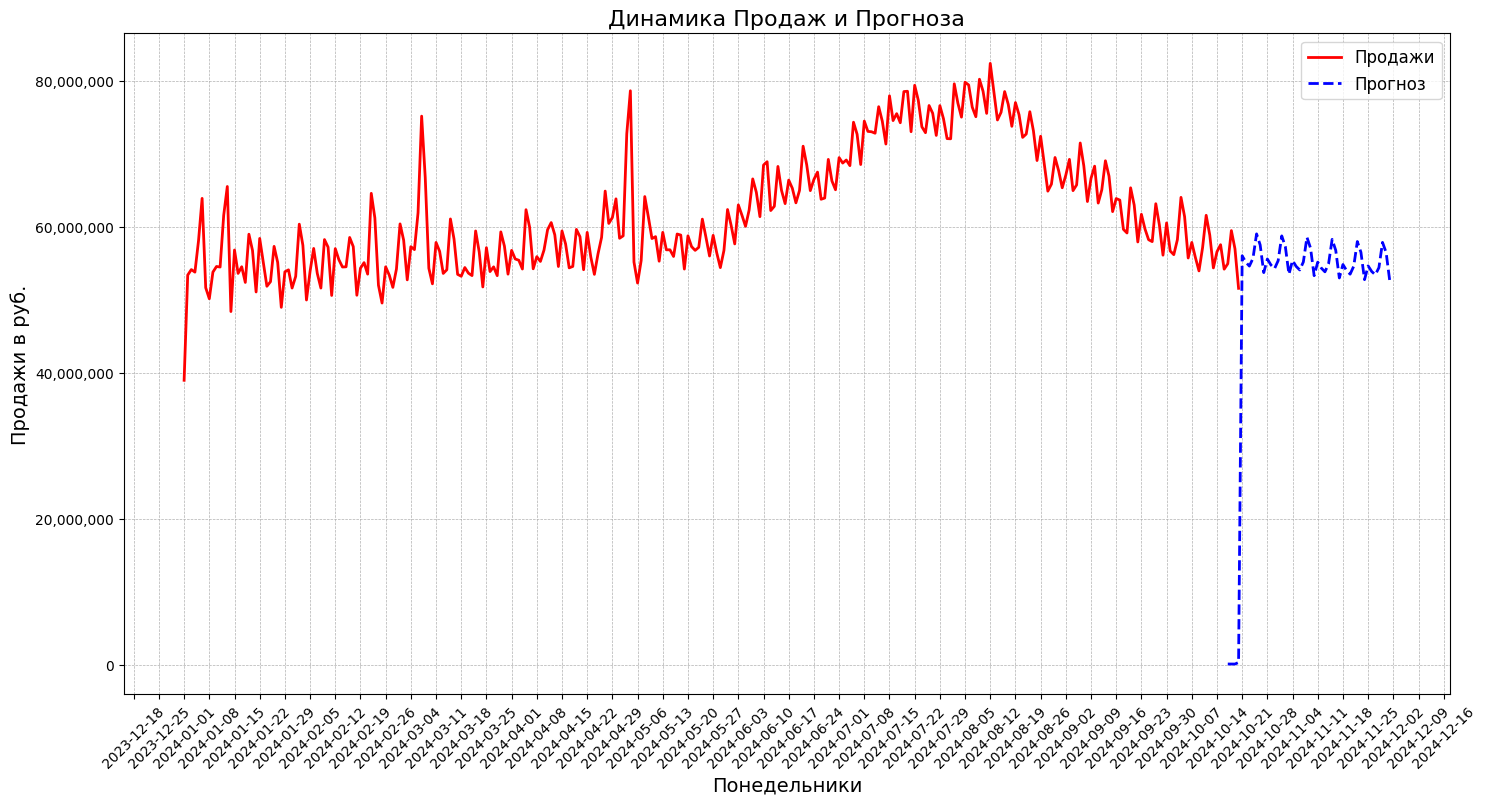

In [1]:
import matplotlib.pyplot as plt                     # График по всем магазинам
import matplotlib.dates as mdates
import pandas as pd

# Загрузка данных прогнозов и фактических продаж
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/NeuralProphet/Magazin/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)

# Переименование столбцов для удобства
data = data.rename(columns={
    'Дата': 'ds', 
    'Номер Магазина': 'store', 
    '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'
})

# Преобразование столбца 'y' в числовой формат
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Фильтрация данных начиная с 2024 года
data = data[data['ds'] >= '2024-01-01']

# Суммирование фактических данных по всем магазинам
total_sales = data.groupby('ds').agg({'y': 'sum'}).reset_index()

# Загрузка прогнозов
all_forecasts = pd.read_excel('Forecast_NeuralProphet.xlsx', index_col=None)  # Измени имя файла, если нужно
all_forecasts['ds'] = pd.to_datetime(all_forecasts['ds'])
filtered_forecasts = all_forecasts[all_forecasts['ds'] >= '2024-01-01']

# Суммирование прогнозов по всем магазинам
summed_forecasts = filtered_forecasts.groupby('ds').agg({'yhat1': 'sum'}).reset_index()  # Измени 'yhat' на 'yhat1'

# Создание общего графика суммарного прогноза с фактическими данными
plt.figure(figsize=(14, 8))

# Линия фактических продаж
plt.plot(total_sales['ds'], total_sales['y'], label='Продажи', color='red', linewidth=2)

# Линия суммарного прогноза
plt.plot(summed_forecasts['ds'], summed_forecasts['yhat1'], label='Прогноз', color='blue', linestyle='--', linewidth=2)  # Измени 'yhat' на 'yhat1'

# Настройка заголовка и меток осей
plt.title('Динамика Продаж и Прогноза', fontsize=16)
plt.xlabel('Понедельники', fontsize=14)
plt.ylabel('Продажи в руб.', fontsize=14)

# Отображение легенды
plt.legend(fontsize=12)

# Отображение сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Улучшение форматирования осей
plt.xticks(rotation=45)
plt.tight_layout()

# Добавление разделителей тысяч для оси Y
plt.gca().get_yaxis().set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Добавление меток начала каждой недели на ось X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Показ графика
plt.show()


Index(['ds', 'store', 'yhat1'], dtype='object')


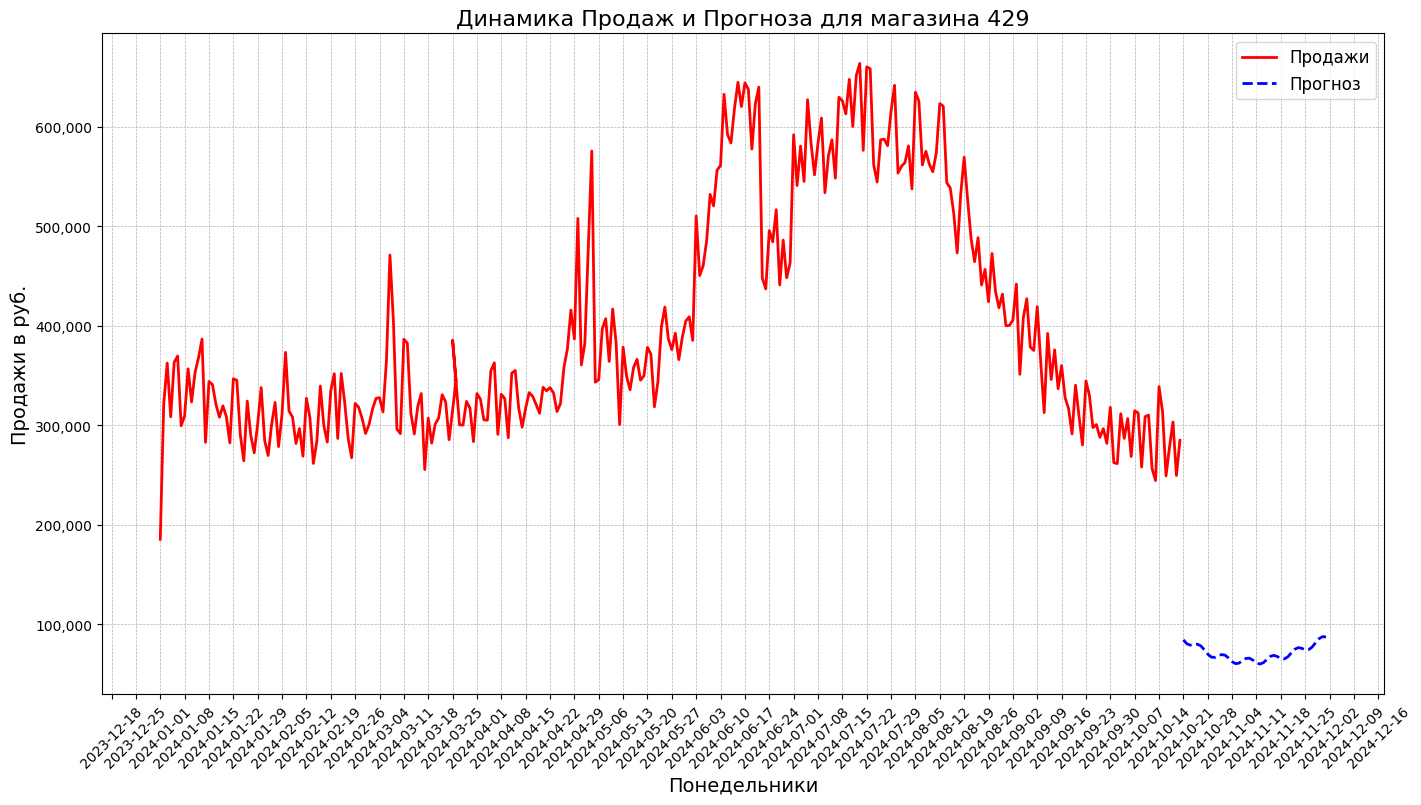

In [4]:
import matplotlib.pyplot as plt                 # График по выбранному магазину
import matplotlib.dates as mdates
import pandas as pd

# Загрузка данных прогнозов и фактических продаж
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/NeuralProphet/Magazin/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)

# Переименование столбцов для удобства
data = data.rename(columns={
    'Дата': 'ds', 
    'Номер Магазина': 'store', 
    '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'
})

# Преобразование столбца 'y' в числовой формат
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Фильтрация данных начиная с 2024 года
data = data[data['ds'] >= '2024-01-01']

# Фильтрация данных по выбранному магазину (например, магазин с ID 148)
store_id = 429
store_data = data[data['store'] == store_id]

# Загрузка прогнозов
all_forecasts = pd.read_excel('Forecast_NeuralProphet.xlsx', index_col=None)

# Вывод доступных столбцов для диагностики
print(all_forecasts.columns)  # Добавлено для отладки

# Проверка названия столбца 'ds'
if 'ds' in all_forecasts.columns:
    all_forecasts['ds'] = pd.to_datetime(all_forecasts['ds'])
else:
    all_forecasts[' Дата'] = pd.to_datetime(all_forecasts[' Дата'])  # Измени имя, если нужно

filtered_forecasts = all_forecasts[all_forecasts['ds'] >= '2024-01-01']  # Измените имя столбца при необходимости

# Фильтрация прогнозов по выбранному магазину
store_forecasts = filtered_forecasts[filtered_forecasts['store'] == store_id]

# Создание графика прогноза с фактическими данными для выбранного магазина
plt.figure(figsize=(14, 8))

# Линия фактических продаж
plt.plot(store_data['ds'], store_data['y'], label='Продажи', color='red', linewidth=2)

# Линия прогноза
plt.plot(store_forecasts['ds'], store_forecasts['yhat1'], label='Прогноз', color='blue', linestyle='--', linewidth=2)

# Настройка заголовка и меток осей
plt.title(f'Динамика Продаж и Прогноза для магазина {store_id}', fontsize=16)
plt.xlabel('Понедельники', fontsize=14)
plt.ylabel('Продажи в руб.', fontsize=14)

# Отображение легенды
plt.legend(fontsize=12)

# Отображение сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Улучшение форматирования осей
plt.xticks(rotation=45)
plt.tight_layout()

# Добавление разделителей тысяч для оси Y
plt.gca().get_yaxis().set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Добавление меток начала каждой недели на ось X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Показ графика
plt.show()
